In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from math import ceil

import thinkplot
from thinkstats2 import Cdf
from thinkstats2 import RandomSeed

from matplotlib import rc
rc('animation', html='html5')

from Cell2D import Cell2D, Cell2DViewer

def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.
    
    n: int number of rows
    m: int number of cols
    
    returns: NumPy array
    """
    left = np.repeat(np.arange(m), n)
    right = np.tile(np.arange(n), m)
    return np.transpose([left, right])

def make_visible_locs(vision):
    """Computes the kernel of visible cells.
        
    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a
                     
    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

In [2]:
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""
    
    def __init__(self, n, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params
        
        # track variables
        self.agent_count_seq = []
        self.rabbit_count_seq = []
        self.fox_count_seq = []
        self.grass_count_seq = []
    
        # make the capacity array
        self.capacity = self.make_capacity()
        
        # initially all cells are at capacity
        self.array = self.capacity.copy()
        
        # make the agents
        self.make_agents()
        
    def make_capacity(self):
        a = np.zeros((self.n, self.n), np.float)
        a[True] = self.params.get('grass_capacity',2)
        return a
        
    def make_agents(self):
        """Makes the agents."""
        
        # determine where the agents start and generate locations
        n, m = self.params.get('starting_box', self.array.shape)
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_rabbits = self.params.get('num_rabbits', 75)
        num_foxs = self.params.get('num_foxs', 10)
        self.agents = [Rabbit(locs[i], self.params) for i in range(num_rabbits)]+[Fox(locs[i+num_rabbits], self.params) for i in range(num_foxs)]
        
        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)
            
    def grow(self):
        """Adds grass to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 0.1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)
        
    def reproduce(self,mult_rabbits,mult_foxs,pop_rabbits,pop_foxs):
        rate_rabbits = ceil(mult_rabbits*pop_rabbits)
        rate_foxs = ceil(mult_foxs*pop_foxs)
        for a in range(0,rate_rabbits):
            self.add_rabbit()    
        for b in range(0,rate_foxs):
            self.add_fox()
        
    def look_around(self, center, vision, carnivore):
        """Finds the visible cell with the most sugar.
        
        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance
        
        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n
        
        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]
        
        # select unoccupied cells
        if (carnivore):
            food = [agent for agent in self.agents if type(agent) is Rabbit]
            empty_locs = [animal.loc for animal in food if animal.loc in locs]
        else:
            empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center
        
        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]
        
        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]
    
    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.
        
        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar
    
    def eat(self, loc):
        agent = next(agent for agent in self.agents if agent.loc is loc)
        self.agents.remove(agent)
        if (loc in self.occupied):
            self.occupied.remove(loc)
        meat_bonus = self.params.get('meat_bonus', 1)
        return agent.grass+meat_bonus
    
    def step(self):
        """Executes one time step."""
        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            if (agent.loc in self.occupied and agent in self.agents):
                # mark the current cell unoccupied
                self.occupied.remove(agent.loc)
            
                # execute one step
                agent.step(self)

                # if the agent is dead, remove from the list
                if agent.is_starving() or agent.is_old():
                    self.agents.remove(agent)
                else:
                    # otherwise mark its cell occupied
                    self.occupied.add(agent.loc)

        # update the time series
        self.agent_count_seq.append(len(self.agents))
        rabbit_pop = len([agent for agent in self.agents if type(agent) is Rabbit])
        fox_pop = len([agent for agent in self.agents if type(agent) is Fox])
        self.rabbit_count_seq.append(rabbit_pop)
        self.fox_count_seq.append(fox_pop)
        
        
        # grow back some sugar
        self.grow()
        self.grass_count_seq.append(sum(map(sum, self.array)))
        rabbit_mult = self.params.get('rabbit_mult', 0.2)
        fox_mult = self.params.get('fox_mult', 0.05)
        self.reproduce(rabbit_mult,fox_mult,rabbit_pop,fox_pop)
        return len(self.agents)
    
    def add_rabbit(self):
        """Generates a new random agent.
                
        returns: new Agent
        """
        new_agent = Rabbit(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent
    
    def add_fox(self):
        new_agent = Fox(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent
    
    def random_loc(self):
        """Choose a random unoccupied cell.
        
        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

In [3]:
class SugarscapeViewer(Cell2DViewer):
    """Generates visualization and animation of Sugarscape."""
    
    cmap = plt.get_cmap('Greens')
    
    options = dict(interpolation='none', alpha=0.8,
                   vmin=0, vmax=9)
    
    def draw(self, grid=False):
        """Draws the array and any other elements.
        
        grid: boolean, whether to draw grid lines
        """
        self.draw_array(self.viewee.array, origin='lower')
        self.draw_agents()

    def draw_agents(self):
        """Plots the agents.
        """
        xs, ys, animals = self.get_coords()
        for x, y, animal in zip(xs, ys, animals):
            if (animal is Rabbit):
                self.points = plt.plot(x, y, '.', color='black')[0]
            elif (animal is Fox):
                self.points = plt.plot(x, y, '.', color='orange')[0]
        
    def animate_func(self, i):
        """Draws one frame of the animation."""
        Cell2DViewer.animate_func(self, i)
        plt.clf()
        self.draw()
        return self.im, self.points
    
    def get_coords(self):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        agents = self.viewee.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        animals = []
        for agent in agents:
            animals.append(type(agent))
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys, animals

In [4]:
class Agent:
    
    def __init__(self, loc, params): raise NotImplementedError

    def step(self, env): raise NotImplementedError

    def is_starving(self): raise NotImplementedError
    
    def is_old(self): raise NotImplementedError
    

In [5]:
class Rabbit(Agent):
    def __init__(self, loc, params):
        """Creates a new agent at the given location.
        
        loc: tuple coordinates
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0
        
        # extract the parameters
        min_vision = params.get('min_vision_rabbit', 3)
        max_vision = params.get('max_vision_rabbit', 6)
        min_metabolism = params.get('min_metabolism_rabbit', 2)
        max_metabolism = params.get('max_metabolism_rabbit', 4)
        min_lifespan = params.get('min_lifespan', 12)
        max_lifespan = params.get('max_lifespan', 24)
        min_grass = params.get('min_grass', 5)
        max_grass = params.get('max_grass', 25)
        
        # choose attributes
        self.vision = np.random.random_integers(min_vision, max_vision)
        self.metabolism = np.random.uniform(min_metabolism, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.grass = np.random.uniform(min_grass, max_grass)

    def step(self, env):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        self.loc = env.look_around(self.loc, self.vision, False)
        self.grass += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checks if grass has gone negative."""
        return self.grass < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

In [ ]:
class Fox(Agent):
    def __init__(self, loc, params):
        """Creates a new agent at the given location.
        
        loc: tuple coordinates
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0
        
        # extract the parameters
        min_vision = params.get('min_vision_fox', 15)
        max_vision = params.get('max_vision_fox', 25)
        min_metabolism = params.get('min_metabolism_fox', 2)
        max_metabolism = params.get('max_metabolism_fox', 4)
        min_lifespan = params.get('min_lifespan_fox', 24)
        max_lifespan = params.get('max_lifespan_fox', 48)
        min_rabbit = params.get('min_rabbit', 5)
        max_rabbit = params.get('max_rabbit', 25)
        
        # choose attributes
        self.vision = np.random.random_integers(min_vision, max_vision)
        self.metabolism = np.random.uniform(min_metabolism, max_metabolism)
        self.lifespan = np.random.uniform(min_lifespan, max_lifespan)
        self.rabbit = np.random.uniform(min_rabbit, max_rabbit)

    def step(self, env):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        togo = env.look_around(self.loc, self.vision, True)
        if (togo is not self.loc):
            self.rabbit += env.eat(togo) - self.metabolism
            self.loc = togo
        self.age += 1

    def is_starving(self):
        """Checks if food has gone negative."""
        return self.rabbit < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

In [ ]:
env = Sugarscape(100)
viewer = SugarscapeViewer(env)
anim = viewer.animate(frames=100)
anim

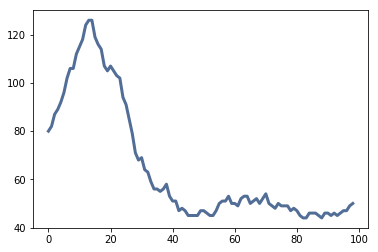

In [156]:
thinkplot.plot(env.agent_count_seq)

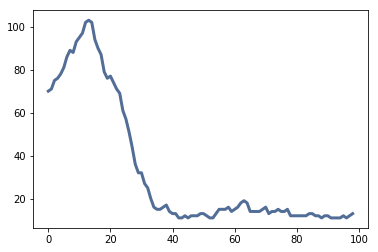

In [157]:
thinkplot.plot(env.rabbit_count_seq)

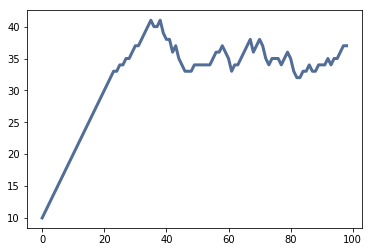

In [158]:
thinkplot.plot(env.fox_count_seq)

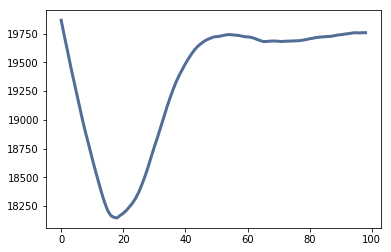

In [159]:
thinkplot.plot(env.grass_count_seq)

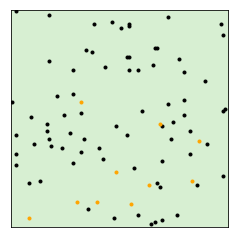

In [143]:
viewer.draw()

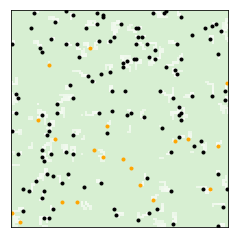

In [153]:
viewer.step()
viewer.draw()